In [11]:
# Preprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Wind Dataset KU.csv', usecols = [0,3], index_col = 0, parse_dates=[0], dayfirst=True)
df.dropna(inplace=True)
#print(df)

training_set = df.iloc[:60180,0:1].values
test_set = df.iloc[60180:,0:1].values

#scaling the values 
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0,1))

training_set_scaled = sc.fit_transform(training_set)  
test_set_scaled = sc.fit_transform(test_set)

X_train = []
y_train = []
WS = 144

for i in range(WS, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-WS:i, 0:1])
    y_train.append(training_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
print(df)


                     Wind Speed
Date & Time                    
2015-09-14 17:00:00         0.6
2015-09-14 17:10:00         0.4
2015-09-14 17:20:00         1.7
2015-09-14 17:30:00         2.0
2015-09-14 17:40:00         1.1
...                         ...
2016-07-11 14:10:00         1.8
2016-07-11 14:20:00         1.5
2016-07-11 14:30:00         1.8
2016-07-11 14:40:00         1.8
2016-07-11 14:50:00         1.5

[60468 rows x 1 columns]


In [3]:
# Developing LSTM Model

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

Model_P = Sequential()

Model_P.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1],1)))
Model_P.add(Dropout(0.2))

Model_P.add(LSTM(units = 60, return_sequences = True))
Model_P.add(Dropout(0.2))

Model_P.add(LSTM(units = 60, return_sequences = True))
Model_P.add(Dropout(0.2))

Model_P.add(LSTM(units = 60))
Model_P.add(Dropout(0.2))

Model_P.add(Dense(units = 1))

Model_P.compile(optimizer = 'adam', loss = 'mean_squared_error')

Model_P.fit(X_train, y_train, epochs = 30, batch_size = 32)

Model_P.save('LSTM - UniVariatKU')

Epoch 1/30
1877/1877 [==============================] - 294s 154ms/step - loss: 0.0017
Epoch 2/30
1877/1877 [==============================] - 454s 242ms/step - loss: 0.0010
Epoch 3/30
1877/1877 [==============================] - 424s 226ms/step - loss: 0.0010
Epoch 4/30
1877/1877 [==============================] - 431s 230ms/step - loss: 0.0010
Epoch 5/30
1877/1877 [==============================] - 431s 230ms/step - loss: 0.0010
Epoch 6/30
1877/1877 [==============================] - 429s 228ms/step - loss: 9.9110e-04
Epoch 7/30
1877/1877 [==============================] - 438s 233ms/step - loss: 9.8574e-04
Epoch 8/30
1877/1877 [==============================] - 437s 233ms/step - loss: 9.8286e-04
Epoch 9/30
1877/1877 [==============================] - 434s 231ms/step - loss: 9.8422e-04
Epoch 10/30
1877/1877 [==============================] - 432s 230ms/step - loss: 9.7850e-04
Epoch 11/30
1877/1877 [==============================] - 432s 230ms/step - loss: 9.6931e-04
Epoch 12/30
1877/

INFO:tensorflow:Assets written to: LSTM - UniVariatKU\assets


INFO:tensorflow:Assets written to: LSTM - UniVariatKU\assets


In [4]:
#Predicting the Wind Speed
from keras.models import load_model
Model_P = load_model('LSTM - UniVariatKU')

prediction_test = []

Batch_one = training_set_scaled[-WS:]
Batch_New = Batch_one.reshape((1,WS,1))

for i in range(288):
    
    First_Pred = Model_P.predict(Batch_New)[0]
    
    prediction_test.append(First_Pred)
    
    Batch_New = np.append(Batch_New[:,1:,:], [[First_Pred]], axis = 1)
    

prediction_test = np.array(prediction_test)

predictions = sc.inverse_transform(prediction_test)

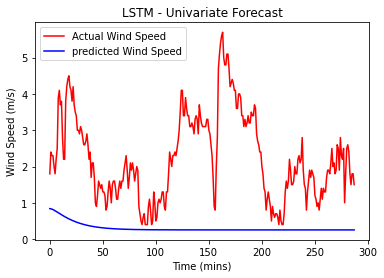

In [5]:
#Plotting result

plt.plot(test_set, color = 'red', label = 'Actual Wind Speed')
plt.plot(predictions, color = 'blue', label = 'predicted Wind Speed')
plt.title('LSTM - Univariate Forecast')
plt.xlabel('Time (mins)')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.show()

In [6]:
import math

from sklearn.metrics import mean_squared_error

RMSE = math.sqrt(mean_squared_error(test_set, predictions))

print(RMSE)

2.25718249780282


In [7]:
def mean_absolute_percentage_error (y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

MAPE = mean_absolute_percentage_error(test_set,predictions)
print(MAPE)

81.6552760719319


In [9]:
tm = test_set.mean()

pm = predictions.mean()
print(tm)
print(pm)

2.240277777777778
0.3034414


In [10]:
tstd = test_set.std()
pmstd = predictions.std()
print(tstd)
print(pmstd)

1.1760526871018604
0.12124328
